In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from baseline.data import MoleculeDatapoint, MoleculeDataset
from baseline.models import FeedForwardNetwork, evaluate, train_one_epoch
from baseline.splits import split_data
from baseline.utils import get_fingerprint, make_rdkit_mol
from baseline.featurizers import MorganFeaturizer

/tmp/ipykernel_588772/2526559193.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
path = "/home/hwpang/Projects/BaselineML/data/biogen_solubility.csv"
data_df = pd.read_csv(path)

In [3]:
data_df["mol"] = data_df["SMILES"].apply(make_rdkit_mol)

In [4]:
datapoints = [
    MoleculeDatapoint(
        mol,
        solubility,
        featurizer=MorganFeaturizer(),
    )
    for mol, solubility in zip(data_df["mol"], data_df["logS"])
]

In [5]:
train_dpoints, val_dpoints, test_dpoints = split_data(datapoints)

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
train_dset = MoleculeDataset(train_dpoints)
val_dset = MoleculeDataset(val_dpoints)
test_dset = MoleculeDataset(test_dpoints)

feature_scaler = train_dset.normalize_features()
val_dset.normalize_features(feature_scaler)
test_dset.normalize_features(feature_scaler)

label_scaler = train_dset.normalize_labels()
val_dset.normalize_labels(label_scaler)
test_dset.normalize_labels(label_scaler)

train_dset.to(device)
val_dset.to(device)
test_dset.to(device)

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dset, batch_size=64, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(val_dset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dset, shuffle=False)

In [9]:
model = FeedForwardNetwork(
    input_size=2048,
    hidden_size=512,
    output_size=1,
    n_layers=3,
    dropout=0.1,
    activation="ReLU",
).to(device)
print(model)

FeedForwardNetwork(
  (activation): ReLU()
  (sequences): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [10]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    print(f"Epoch {epoch+1}/{n_epochs}")
    train_one_epoch(train_dataloader, model, loss_function, optimizer)

    train_loss = evaluate(train_dataloader, model, loss_function)
    print(f"Training Loss: {train_loss}")
    val_loss = evaluate(valid_dataloader, model, loss_function)
    print(f"Validation Loss: {val_loss}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


 20%|██        | 2/10 [00:02<00:08,  1.07s/it]

Training Loss: 0.2987717842417104
Validation Loss: 0.8203058689832687
Epoch 2/10
Training Loss: 0.08235585130751133
Validation Loss: 0.6928192973136902
Epoch 3/10
Training Loss: 0.056382776969777684


 40%|████      | 4/10 [00:02<00:02,  2.37it/s]

Validation Loss: 0.7260102927684784
Epoch 4/10
Training Loss: 0.038581825393651216
Validation Loss: 0.626066654920578
Epoch 5/10
Training Loss: 0.021706932756517614
Validation Loss: 0.5963998138904572
Epoch 6/10


 60%|██████    | 6/10 [00:02<00:00,  4.08it/s]

Training Loss: 0.016385338235912577
Validation Loss: 0.6138813123106956
Epoch 7/10
Training Loss: 0.013362118292466871
Validation Loss: 0.7195767462253571
Epoch 8/10
Training Loss: 0.01608848004668419


 90%|█████████ | 9/10 [00:03<00:00,  6.13it/s]

Validation Loss: 0.6681292504072189
Epoch 9/10
Training Loss: 0.018693045613222888
Validation Loss: 0.6220250725746155
Epoch 10/10
Training Loss: 0.020908702996426394


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]

Validation Loss: 0.7483351528644562


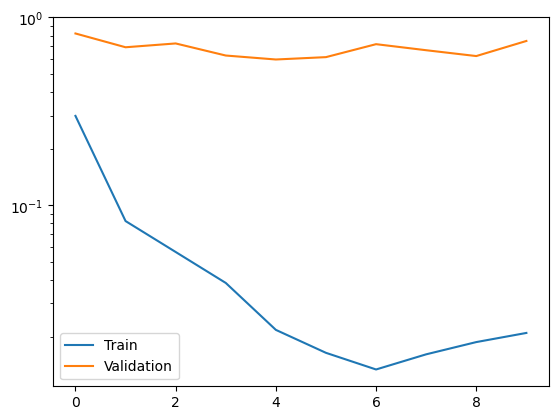

In [11]:
plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.yscale("log")

In [12]:
y_preds = []
with torch.no_grad():
    for x, y in test_dataloader:
        y_pred = model(x)
        y_pred = y_pred.cpu().numpy().ravel()
        y_preds.append(y_pred)

y_preds = label_scaler.inverse_transform(np.vstack(y_preds))
y_true = label_scaler.inverse_transform(test_dset.labels.cpu().numpy())

In [13]:
test_dset.labels.cpu().numpy()

array([[-1.2652727 ],
       [ 0.35623294],
       [ 0.35020494],
       [-0.58705455],
       [-2.0224376 ],
       [ 0.63037235],
       [ 0.5435189 ],
       [-0.3898072 ],
       [ 0.80955696],
       [ 0.10025226],
       [ 0.68188584],
       [ 0.55026084],
       [ 0.6481575 ],
       [-1.0534201 ],
       [ 0.5266191 ],
       [ 0.36167395],
       [ 0.6707632 ],
       [ 0.6175628 ],
       [ 0.5771712 ],
       [ 0.7098619 ],
       [ 0.6467266 ],
       [ 0.5732153 ],
       [-1.7613895 ],
       [-1.9554231 ],
       [ 0.5945389 ],
       [ 0.33655623],
       [ 0.9986184 ],
       [-1.5688268 ],
       [ 0.720964  ],
       [ 0.02771097],
       [ 0.39457127],
       [ 0.50639874],
       [-2.0214446 ],
       [ 0.20561785],
       [ 0.8062621 ],
       [ 0.5724078 ],
       [ 0.48708212],
       [-1.0917443 ],
       [ 0.59252244],
       [ 0.53231686],
       [ 0.71659267],
       [ 0.5292808 ],
       [ 0.2808377 ],
       [ 0.68291074],
       [ 0.59562415],
       [-1

Text(0, 0.5, 'Prediction')

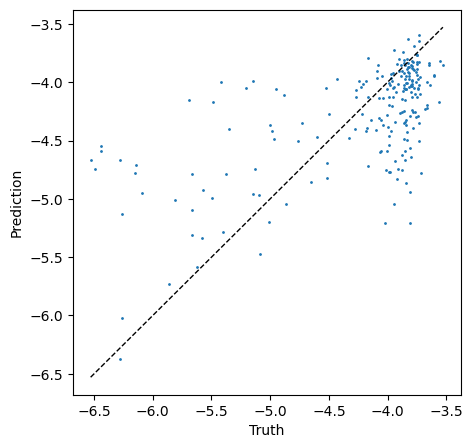

In [14]:
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_preds, s=1)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "k--", lw=1)
plt.xlabel("Truth")
plt.ylabel("Prediction")